## Classification of hazard in coal mines based on seismic data

### Load dependencies

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import pandas as pd
import seaborn as sns;

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import preprocessing

%matplotlib inline

### Load and clean data

In [5]:
## load data and clean

data = arff.loadarff('./data/seismic-bumps.arff')
df = pd.DataFrame(data[0])
df['seismic'] = df['seismic'].str.decode('utf-8')
df['seismoacoustic'] = df['seismoacoustic'].str.decode('utf-8')
df['shift'] = df['shift'].str.decode('utf-8')
df['ghazard'] = df['ghazard'].str.decode('utf-8')
df['class'] = df['class'].str.decode('utf-8')
df['class'] = pd.to_numeric(df['class'])
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### EDA

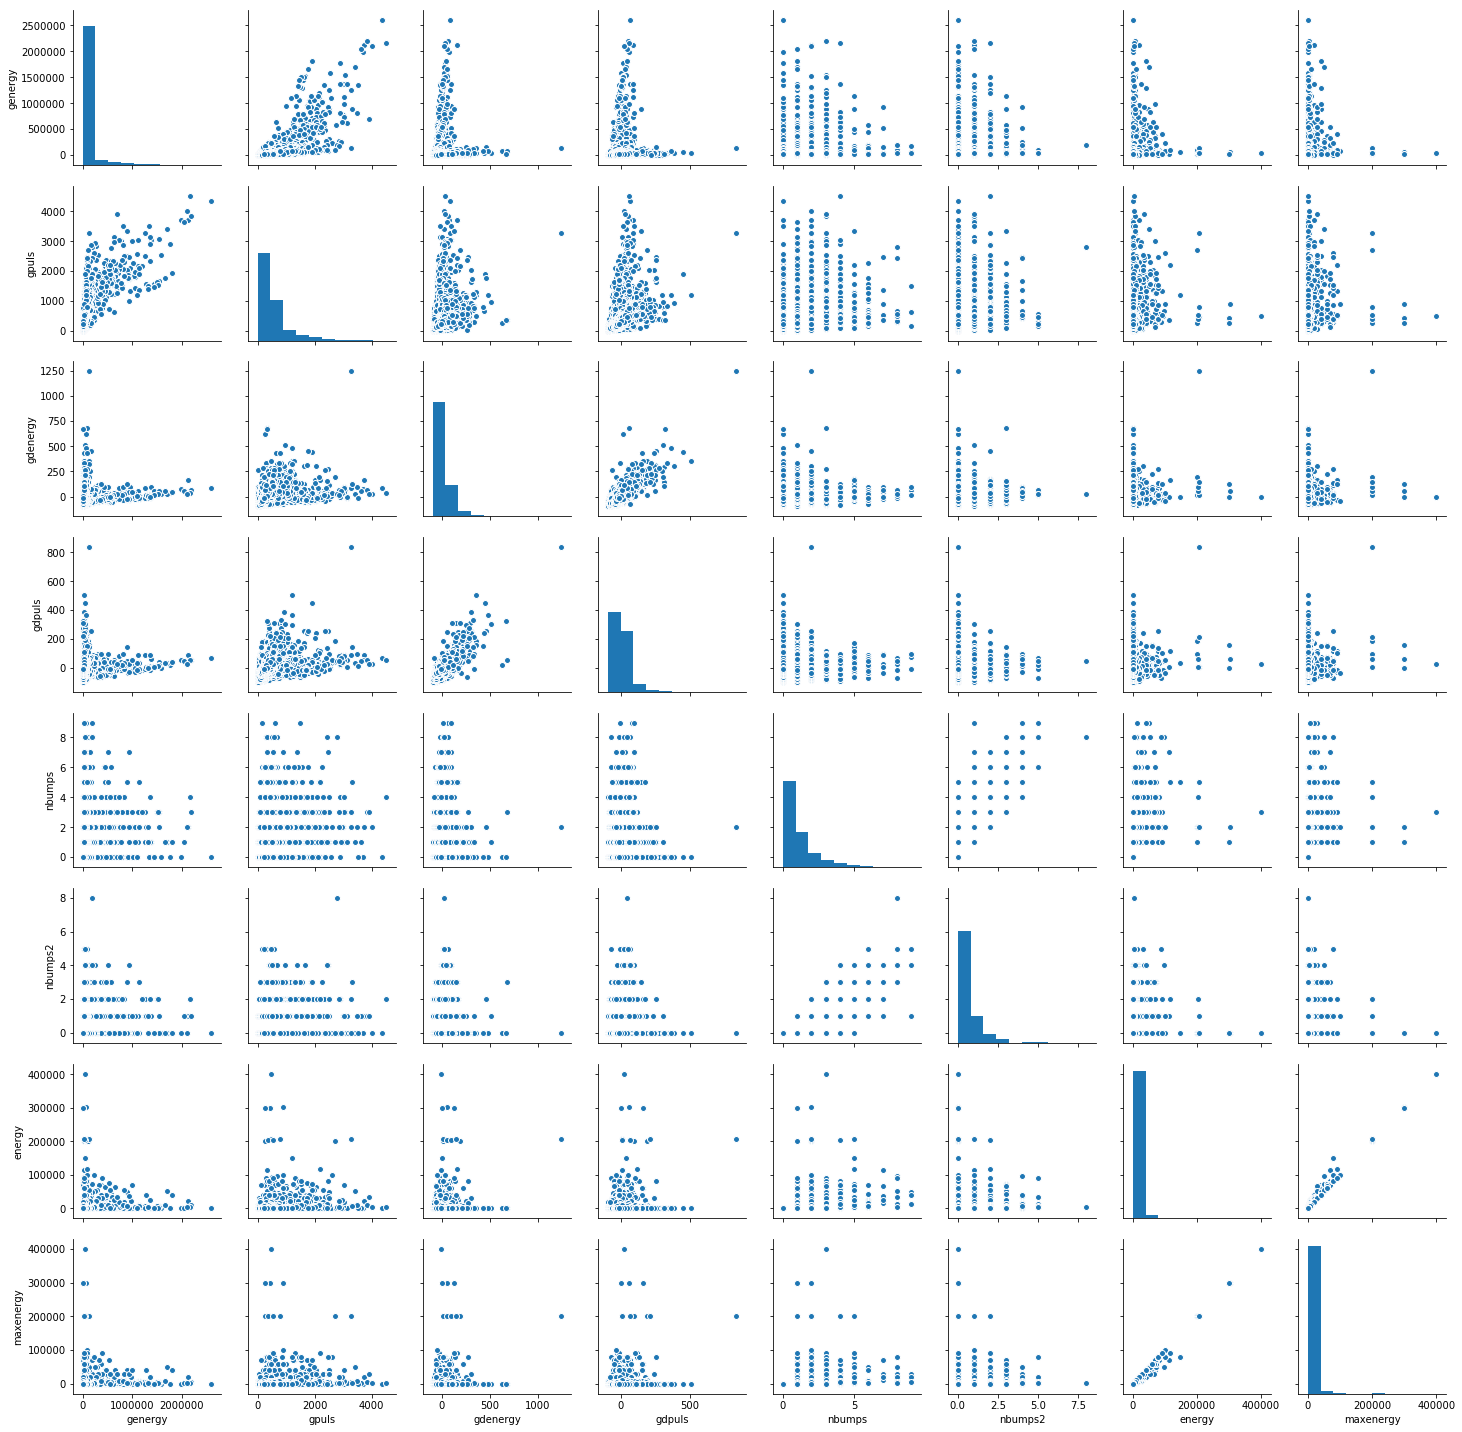

In [6]:
## EDA
df1 = df[['genergy', 'gpuls', 'gdenergy', 'gdpuls',
          'nbumps', 'nbumps2',
          'energy', 'maxenergy']].copy()
g = sns.pairplot(df1)

The plots above show some colinearity between attributes (e.g. `genergy` and `gpuls`, `energy` and `maxenergy`). The following will use regularization to mitigate the problem.

### Build models

In [7]:
df_x = df.loc[:,['shift', 'genergy', 'gpuls', 'gdenergy', 'gdpuls',
               'nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5',
               'nbumps6', 'nbumps7', 'nbumps89', 
               'energy', 'maxenergy']]

# true response
df_y = df.loc[:,['class']]

# responses from seismic theories
df_y1 = df.loc[:, ['seismic']]
df_y2 = df.loc[:, ['seismoacoustic']]
df_y3 = df.loc[:, ['ghazard']]


le = preprocessing.LabelEncoder()
le.fit(['a', 'b', 'c', 'd'])
df_y1['seismic'] = le.transform(df_y1['seismic'])
df_y2['seismoacoustic'] = le.transform(df_y2['seismoacoustic'])
df_y3['ghazard'] = le.transform(df_y3['ghazard'])

le2 = preprocessing.LabelEncoder()
le2.fit(['W', 'N'])
df_x['shift'] = le2.transform(df_x['shift'])

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

print("Xtrain shape: ", Xtrain.shape)
print("Xtest shape: ", Xtest.shape)

Xtrain shape:  (2067, 15)
Xtest shape:  (517, 15)


In [9]:
## find the best regularization coefficient
## use ROC as the score

C = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2]
scores = []

for c in C:
    logit = LogisticRegression(penalty='l1', C=c, max_iter=500)
    logit.fit(Xtrain, ytrain.values.ravel())
    scores.append(roc_auc_score(ytrain['class'].values, logit.predict(Xtrain)))

C_best = C[scores.index(max(scores))]
print("Best C: ", C_best)

Best C:  0.1


In [10]:
clf = LogisticRegression(penalty='l1', C=C_best, max_iter = 500)
clf.fit(Xtrain, ytrain.values.ravel())

roc_train = roc_auc_score(ytrain['class'].values, clf.predict(Xtrain))
# print("training score: %.4f" % clf.score(Xtrain, ytrain))
print("training score: %.4f" % roc_train)
# print("test score: ", clf.score(Xtest, ytest))
roc_test = roc_auc_score(ytest['class'].values, clf.predict(Xtest))
print("test score: %.4f" % roc_test)
print("n_iter: ", clf.n_iter_)

training score: 0.5100
test score: 0.5000
n_iter:  [31]


In [11]:
clf.coef_

array([[  0.00000000e+00,  -7.26734648e-07,   9.39629296e-04,
         -1.14764634e-03,  -1.81499205e-03,   3.34517198e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -2.14513939e-05,   1.69667403e-05]])

In [12]:
ind = ytest.index.values

# get the responses from the seismic, seismoacoustic and ghazard methods
# that correspond to indices in ytest
yseismic = df_y1.loc[ind, ['seismic']]
yseismoacoustic = df_y2.loc[ind, ['seismoacoustic']]
yghazard = df_y3.loc[ind, ['ghazard']]

In [13]:
# responses as probabilies from the logit model
yprob = clf.predict_proba(Xtest)

In [14]:
ypred = yprob[:,1] > 0.2  # threshold

From the plot below, to use the probabilites from the prediction, we need to set a threshold to determine if the response should be hazardous or not. The hard labels from the prediction will be mostly 0's.

_Note:_ setting the threshold requires further study. One way is to tune the threshold in training sets and test the performance in test sets.

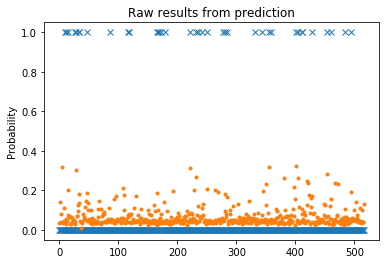

In [15]:
plt.plot([i for i in range(len(ytest))], ytest, 'x', yprob[:,1], '.')
plt.ylabel('Probability')
plt.title('Raw results from prediction')

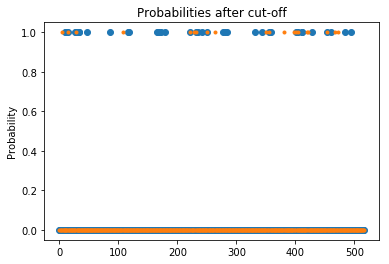

In [16]:
plt.plot([i for i in range(len(ytest))], ytest, 'o', ypred, '.')
plt.ylabel('Probability')
plt.title('Probabilities after cut-off')

### Results

In [17]:
dy = { 'logit': pd.Series(ypred) }
dfy = pd.DataFrame(dy)
frames = [dfy, yseismic.reset_index(drop=True),
          yseismoacoustic.reset_index(drop=True),
          yghazard.reset_index(drop=True)]

# build the responses data frame (each column is responses from one method)
df_result = pd.concat(frames, axis = 1)
df_result = df_result*1  # convert bool to int

In [18]:
df_result.head()

,logit,seismic,seismoacoustic,ghazard
0,0,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,0


In [19]:
yvote = (df_result == 0).sum(axis=1)  # number of zeros on each row
yvote = (yvote <= 2)*1

# final results based on the vote from each of the four methods
# 0 means no/low hazard, 1 means hazardous
# if tie, assume response is 1 (hazardous)
df_result['ensemble'] = yvote.values
df_result['true'] = ytest.values
df_result.head(20)

,logit,seismic,seismoacoustic,ghazard,ensemble,true
0,0,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,0,0,0
5,1,1,1,0,1,0
6,0,0,0,0,0,0
7,0,1,1,0,1,0
8,0,1,1,0,1,0
9,0,0,0,0,0,0


In [20]:
# score from the ensemble method with logit regression
roc_auc_score(ytest['class'].values, df_result['ensemble'].values)

0.57463400900900896

In [21]:
## compare to the three methods already in the dataset

frames = [yseismic.reset_index(drop=True),
          yseismoacoustic.reset_index(drop=True),
          yghazard.reset_index(drop=True)]
df_result0 = pd.concat(frames, axis = 1)
df_result0 = df_result0*1

yvote0 = (df_result0 == 0).sum(axis=1)
yvote0 = (yvote0 <= 2)*1
df_result0['ensemble'] = yvote0.values
df_result0['true'] = ytest.values
df_result0.head(20)

,seismic,seismoacoustic,ghazard,ensemble,true
0,0,0,0,0,0
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,0,0,0,0,0
5,1,1,0,1,0
6,0,0,0,0,0
7,1,1,0,1,0
8,1,1,0,1,0
9,0,0,0,0,0


In [22]:
# score from the ensemble of the three methods in the original dataset
roc_auc_score(ytest['class'].values, df_result0['ensemble'].values)

0.53786599099099108

In [23]:
# score from the seismic method (no ensemble)
roc_auc_score(ytest['class'].values, yseismic['seismic'].values)

0.56095157657657657

In [24]:
# score from the seismoacoustic method (no ensemble)
roc_auc_score(ytest['class'].values, yseismoacoustic['seismoacoustic'].values)

0.50413851351351358

### Future works

- The logit model is not fit well given the nonlinear nature of the data. A better model is needed in the future.
- The ensemble method is not tested in multiple sets. The performance gain needs to be verified.
- The probability threshold needs to be tuned and isolated from the test set.
- If there are fewer true positives in the dataset, the dataset needs to be balanced first.